In [3]:
#| default_exp interactive

In [4]:
#| hide
from nbdev.showdoc import *
import nbdev
from nbdev import nbdev_export

In [13]:
#| export
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd
import geopandas as gpd
import matplotlib.path as mplp
import ipyleaflet as ipyl
from ipyleaflet import WMSLayer
import ipywidgets as ipyw
import json
import pandas as pd
from ipyleaflet import Map, WMSLayer, basemaps, GeoData
from ipywidgets import HTML
from owslib.wms import WebMapService
import ipywidgets as widgets
from ipywidgets import Label, VBox
from owslib.wfs import WebFeatureService
from requests import Request
import urllib.request, json 


In [14]:
from ITS_LIVE_TOOL import obj_setup

In [15]:
#| export
class Widget():
    '''this is an interactive map widget to streamline access itslive data. 
    left and right click for rgi info about a selected location and corresponding url 
    to ITS_LIVE image pair time series granule
    '''
    def __init__(self):

        self.wms_url = "https://glims.org/geoserver/ows?SERVICE=WMS&"
        self.map, self.label = self.make_map()
        
        self.coordinates_label = widgets.Label(value="Clicked Coordinates: ")
        self.coordinates_output = widgets.Output()
        self.map.on_interaction(self.click_handler)
        self.geojson_layer = self._make_geojson_layer()
        self.wms_layer = self._make_wms_layer()
        self.wms = self._make_wms_obj()
        self.map.geojson_layer = self.map.add(self.geojson_layer)
        self.map.wms_layer = self.map.add(self.wms_layer)
        self.geojson_layer.on_click(self._json_handler)
        self.geojson_layer.on_hover(self._hover_handler)
        self.added_glaciers =  []
        self.urls = []
        self.added_coords = []
        self.added_urls = []

    def make_map(self):
        
        map = ipyl.Map(basemap=basemaps.Esri.WorldImagery, center=(0, 0), zoom=2)
        label = ipyw.Label(layout=ipyw.Layout(width="100%"))
        map.scroll_wheel_zoom = True
        return map, label
        
    def _make_wms_layer(self):

        wms_layer = WMSLayer(
            url = self.wms_url,
            layers = 'GLIMS:RGI',
            transparent=True,
            format = 'image/png'
        )
        return wms_layer
        
    def _make_wms_obj(self):
        wms = WebMapService(self.wms_url)
        return wms

    def _make_geojson_layer(self):
        # geojson layer with hover handler
        with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url:

            geojson_data = json.load(url)
        
        for feature in geojson_data["features"]:
            feature["properties"]["style"] = {
                "color": "grey",
                "weight": 1,
                "fillColor": "grey",
                "fillOpacity": 0.5,
            }
        
        geojson_layer = ipyl.GeoJSON(data=geojson_data, hover_style={"fillColor": "red"})
        return geojson_layer

    def _hover_handler(self, event=None, feature=None, id=None, properties=None):
        self.label.value = properties["zarr_url"]

    def _json_handler(self, event=None, feature=None, id=None, properties=None):
        zarr_url = properties.get("zarr_url", "N/A")
        self.urls.append(zarr_url)
        print(f"Clicked URL: {zarr_url}")
        print("All Clicked URLs:", self.urls)

        #self.added_urls.append(urls)

    def click_handler(self, properties=None, **kwargs):
        
        if kwargs.get('type') == 'contextmenu':
            latlon = kwargs.get('coordinates')
            lat, lon = latlon[0], latlon[1]
            print(f"Clicked at (Lat: {lat}, Lon: {lon})")
            self.added_coords.append([lat, lon])
            
            # Arrange the coordinates
            
            response = self.wms.getfeatureinfo(
                layers=['GLIMS:RGI'],
                srs='EPSG:4326',
                bbox=(lon-0.001,lat-0.001,lon+0.001,lat+0.001),
                size=(1,1),
                format='image/jpeg',
                query_layers=['GLIMS:RGI'],
                info_format="application/json",
                xy=(0,0))
            df = gpd.read_file(response)
            #self.added_glacier.append(df)
            print(f"You have selected the glacier {df['NAME'].values[0]}, ID: {df['RGIID'].values[0]} ")
            #gdf_list.append(df)
            self.added_glaciers.append(df)
            #print(len(self.added_glacier))


            #return gdf_list
            
    def update_coordinates_label(self):
        self.coordinates_label.value = "Clicked Coordinates: " + str(self.coordinates)

    def clear_coordinates(self, b):
        self.coordinates = []
        self.update_coordinates_label()
        
    def get_coordinates(self):
        return self.coordinates
    def display(self):
        return VBox([self.map, self.coordinates_label, self.coordinates_output])

In [16]:
#| hide

w = Widget()

In [17]:
#| hide 

w.display()

In [ ]:
#| hide 
#pd.concat(w.added_glaciers)

,id,CENLON,ZMAX,BGNDATE,ZMIN,RGIID,ASPECT,CENLAT,SLOPE,ZMED,...,TERMTYPE,O2REGION,STATUS,ENDDATE,FORM,SURGING,GLIMSID,O1REGION,NAME,geometry
0,RGI_Alaska.14679,-141.716,3638,20100919,4,RGI60-01.14683,179,60.329,13,1447,...,1,5,0,-9999999,0,9,G218284E60329N,1,Yahtse Glacier,"MULTIPOLYGON (((-141.48470 60.40750, -141.4836..."
0,RGI_Alaska.13631,-142.072,5381,20100910,3,RGI60-01.13635,273,60.461,9,1525,...,2,5,0,-9999999,0,9,G217928E60461N,1,Bering Glacier,"MULTIPOLYGON (((-140.87550 60.64370, -140.8743..."


In [ ]:
#| hide 
#w.added_coords[0]

[60.35915664478289, -141.8789647067248]

In [ ]:
#| hide
def create_glacier_from_click(w_obj, i):
    '''this function takes clicked information (from a single click, not all clicked points) and returns a `Glacier` type object
    '''
    name = w_obj.added_glaciers[i]['NAME']
    rgi_id =  w_obj.added_glaciers[i]['RGIID'].iloc[0]
    utm_crs = str(w_obj.added_glaciers[i].estimate_utm_crs())
    rgi_gpdf = w_obj.added_glaciers[i]
    print(rgi_gpdf)
    glacier = obj_setup.Glacier(name, rgi_id, utm_crs, 'widget', rgi_gpdf)

    return glacier
                                

In [ ]:
#| hide
def create_glacier_point_from_click(w_obj, i, label):
    ''' 
    this function takes clicked information (from a single, most recent click and returns a glacier point object
    '''
    var_ls = ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']


    glacier_pt = obj_setup.Glacier_Point(w_obj.added_glaciers[i]['NAME'], label,  w_obj.added_glaciers[i]['RGIID'].iloc[0], [w_obj.added_coords[i][1], w_obj.added_coords[i][0]], var_ls)
    #note , need to add test for cases where itslive is in a different crs than gpd.estimate_utm_crs() expects
    return glacier_pt
                                                                                                                                

In [ ]:
#| hide 
def create_glacier_centerline_from_click(w_obj, i):
    '''
    this function takes clicked information and returns a glacier centerline object
    '''
    glacier_cl = obj_setup.Glacier_Centerline(w_obj.added_glaciers[i]['NAME'], w_obj.added_glaciers[i]['RGIID'].iloc[0])

    return glacier_cl

## When just one glaciers is clicked / creating a single object: 

In [ ]:
#| hide
glacier = create_glacier_from_click(w, 0)

                 id   CENLON  ZMAX   BGNDATE  ZMIN           RGIID  ASPECT  \
0  RGI_Alaska.14679 -141.716  3638  20100919     4  RGI60-01.14683     179   

   CENLAT  SLOPE  ZMED  ...  TERMTYPE  O2REGION  STATUS   ENDDATE  FORM  \
0  60.329     13  1447  ...         1         5       0  -9999999     0   

  SURGING         GLIMSID O1REGION            NAME  \
0       9  G218284E60329N        1  Yahtse Glacier   

                                            geometry  
0  MULTIPOLYGON (((-141.48470 60.40750, -141.4836...  

[1 rows x 24 columns]
widget
0    RGI60-01.14683
Name: RGIID, dtype: object
0    RGI60-01.14683
Name: RGIID, dtype: object


In [ ]:
#| hide

glacier_pt = create_glacier_point_from_click(w, 0, 'test label')

original xy [-140.5578065432628, 59.95184726377468] 4326 maps to datacube (-3313088.786283357, 322388.10948884307) EPSG:3413
original xy [-140.5578065432628, 59.95184726377468] 4326 maps to datacube (-3313088.786283357, 322388.10948884307) EPSG:3413
subset and load at  24.29 seconds


In [ ]:
#| hide

glacier_cl = create_glacier_centerline_from_click(w, 0)

## When multiple glaciers are selected / creating multiple objects at once:

In [ ]:
#| export
def create_multiple_glacier_objs(w_obj):
    '''wrapper function to create multiple objects from multiple clicks
    '''
    glacier_ls = []

    for i in range(len(w_obj.added_glaciers)):
    
        glacier = create_glacier_from_click(w_obj, i)
        glacier_ls.append(glacier)

    return glacier_ls
    #glacier0, glacier1 = glacier_ls[0], glacier_ls[1]

In [ ]:
#| hide

glacier0, glacier1 = create_multiple_glacier_objs(w)[0], create_multiple_glacier_objs(w)[1]

In [ ]:
#| hide

glacier0.name

0    Seward Glacier
Name: NAME, dtype: object

In [ ]:
#| hide

glacier1.name

0    Bering Glacier
Name: NAME, dtype: object

<Axes: >

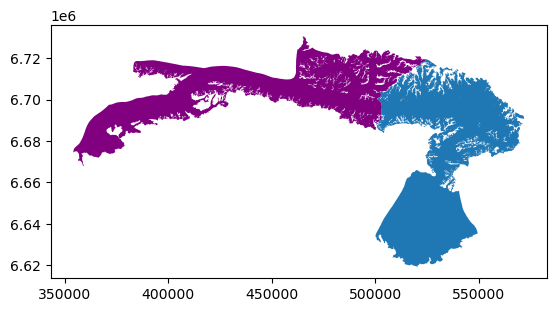

In [ ]:
#| hide

fig, ax = plt.subplots()

glacier0.outline_prj.plot(ax=ax)
glacier1.outline_prj.plot(ax=ax, color='purple')

In [ ]:
#| hide

glacier1.name

0    Bering Glacier
Name: NAME, dtype: object

In [ ]:
#| export

def create_multiple_glacier_point_objs(w_obj):
    '''wrapper function to create multiple glacier point objects from multiple clicks
    '''
    
    glacier_pt_ls = []

    label_ls = ['point 0','point 1']
    
    for i in range(len(w_obj.added_glaciers)):
    
        glacier_pt = create_glacier_point_from_click(w_obj,i, label_ls[i])
        glacier_pt_ls.append(glacier_pt)

    return glacier_pt_ls
   # glacier_pt0, glacier_pt1 = glacier_pt_ls[0], glacier_pt_ls[1]

In [ ]:
#| export

def create_multiple_glacier_centerline_objs(w_obj):
    '''wrapper  function to create multiple glacier centerline objects from multiple clicks 
    '''

    glacier_centerline_ls = []

    for i in range(len(w_obj.added_glaciers)):

        glacier_centerline = create_glacier_centerline_from_click(w_obj, i)
        glacier_centerline_ls.append(glacier_centerline)

    return glacier_centerline_ls

In [ ]:
#| hide
def return_clicked_info(clicked_widget):

    '''this function formats information from a user click on the Widget object. 
    The output is a tuple with the form (coordinate list of clicked point, gpd.geodataframe with rgi info of clicked glacier, url of itslive zarr datacube covering clicked point
    '''
    num_glaciers = len(clicked_widget.added_coords)
    #print(len(clicked_widget.added_coords))
    gpdf_ls = []
    if num_glaciers > 0:
    
        coord_ls = clicked_widget.added_coords
        #coord_ls = [coord_ls[0][1], coord_ls[0][0]]

        gpdf_ls.append(clicked_widget.added_glaciers)
        unique_values, unique_indices = np.unique(np.array([gpdf_ls[0][i]['RGIID'] for i in range(len(gpdf_ls[0]))]), return_index=True)
        #adding victors code here
        #changing obj name -- new object will be gdf_list
        gdf_list = [gpdf_ls[0][i] for i in unique_indices]
        #gpdf = pd.concat(gpdf_ls).drop_duplicates(subset='RGIID')
        #adding victors code here
        #changing obj name -- new object will be gdf_list
       
        print(f'You have {len(gdf_list)} glaciers selected')
    
        #glaciers_gpdf = pd.concat([clicked_widget.added_glacier[i] for i in range(len(clicked_widget.added_glacier))])
    
        urls = list(set(clicked_widget.urls))
    
        return (coord_ls, gdf_list, urls)
    else: 
        print('Select a datacube to fetch the data!!')
        #str = 'The map needs to be clicked for the appropriate object to be created'

        pass

In [ ]:
#| hide

coords, glaciers1, urls  = return_clicked_info(w)

You have 3 glaciers selected
